## Feature Engineering

We'll generate average frequency content over the length of the sample, which should be useful in separating instruments by the strength of their harmonics.

### Create Tables for Harmonic Content of Samples

In [3]:
import config
import mysql
import mysql.connector
from mysql.connector import errorcode

# DB FUNCTIONS

def connect(db_name=None):
    if db_name:
        cnx = mysql.connector.connect(
            host = config.rds_host,
            user = config.rds_user,
            passwd = config.rds_password,
            database = db_name)
    else:
        cnx = mysql.connector.connect(
            host = config.rds_host,
            user = config.rds_user,
            passwd = config.rds_password)
    cursor = cnx.cursor()
    return cursor, cnx


In [ ]:
create_frequency_table_query = '''CREATE TABLE frequencies (
    frequency_id INT NOT NULL,
    frequency DOUBLE NOT NULL,
    log_2_frequency DOUBLE NOT NULL,
    PRIMARY KEY (frequency_id))'''

cur, cnx = connect('instruments')
cur.execute(create_frequency_table_query)
cnx.close()

In [ ]:
import librosa
from math import log

sr = 44100
n_fft = 4096
freqs = librosa.core.fft_frequencies(sr=sr, n_fft=n_fft)[1:]

values = []

for idx, freq in enumerate(freqs):
    values.append( (idx, float(freq), log(freq, 2)) )

frequency_insert_query = '''INSERT INTO frequencies (frequency_id, frequency, log_2_frequency)
                            VALUES (%s, %s, %s)'''
    
cur, cnx = connect('instruments')
cur.executemany(frequency_insert_query, values)
cnx.commit()
cnx.close()

In [ ]:
create_harmonic_content_table_query = '''CREATE TABLE harmonic_content (
                                        sample_id INT NOT NULL,
                                        frequency_id INT NOT NULL,
                                        amplitude DOUBLE NOT NULL,
                                        FOREIGN KEY (sample_id) REFERENCES samples(sample_id),
                                        FOREIGN KEY (frequency_id) REFERENCES frequencies(frequency_id))'''

cur, cnx = connect('instruments')
cur.execute(create_harmonic_content_table_query)
cnx.close()

### Extract Harmonic Content from Samples to Populate Table

In [4]:
import config
import logging
import boto3
from botocore.exceptions import ClientError

def download_file(object_name, bucket='instrument-samples-1337', file_name=None):
    """Download a file from an S3 bucket

    :param object_name: S3 object to download
    :param bucket: Bucket to download from
    :param file_name: file name to download to. If not specified then object_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if file_name is None:
        file_name = object_name

    # Upload the file
    s3_client = boto3.client('s3',
                             aws_access_key_id=config.aws_access_key_id,
                             aws_secret_access_key=config.aws_secret_access_key)
    try:
        response = s3_client.download_file(bucket, object_name, file_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [10]:
import pandas as pd
import librosa.core as lrc
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
from math import log
from IPython.display import display

def perform_stft(sample, sample_rate):
        n_fft = 4096
        stft = librosa.stft(sample, n_fft=n_fft)[1:] # Short Time Fourier Transform
        fig, ax = plt.subplots(figsize=(20,5))
        freqs = librosa.core.fft_frequencies(sr=sample_rate, n_fft=n_fft)[1:]
        log_2_freqs = list(map(lambda x: log(x, 2), freqs))
        ax.plot(log_2_freqs, np.abs(stft).mean(axis=1))
        ax.set_xlabel('log_2 of frequency')
        ax.set_ylabel('average amplitude')
        display(fig)
        plt.close(fig)
        values = []
        print('Inserting harmonic content into database...')
        for idx, value in enumerate(np.abs(stft).mean(axis=1)):
            values.append( (sample_id, idx, float(value)) )
        query = f"""INSERT INTO harmonic_content (sample_id, frequency_id, amplitude)
                    VALUES (%s, %s, %s)"""
        return query, values


def process_sample(sample_id):
    cur, cnx = connect('instruments')
    cur.execute(f"""SELECT * FROM instruments.samples
                    WHERE sample_id = {sample_id}""")
    df = pd.DataFrame(cur.fetchall())
    df.columns = [i[0] for i in cur.description]
    sample_metadata = df.iloc[0]
    print('Attemping to download the following sample:')
    print(sample_metadata)
    sample_id = int(sample_metadata['sample_id'])
    sample_file_ext = sample_metadata['file_extension']
    object_name = f'{str(sample_id)}.{sample_file_ext}'
    print(object_name)
    if download_file(object_name):
        print('Analyzing sample...')
        y, sr = lrc.load(object_name, sr=None)
        query, values = perform_stft(y, sr)
        cur.executemany(query, values)
        os.remove(object_name)
        cnx.commit()
        cnx.close()
        print('Done!')
    else:
        print('Download failed.')
        cnx.close()

In [ ]:
for i in range(1,2338):
    process_sample(i)

Attemping to download the following sample:
sample_id                1847
instrument_name     Xylophone
note                      Eb5
expression         hardrubber
source               Iowa2012
file_extension            aif
Name: 0, dtype: object
1847.aif
Analyzing sample...


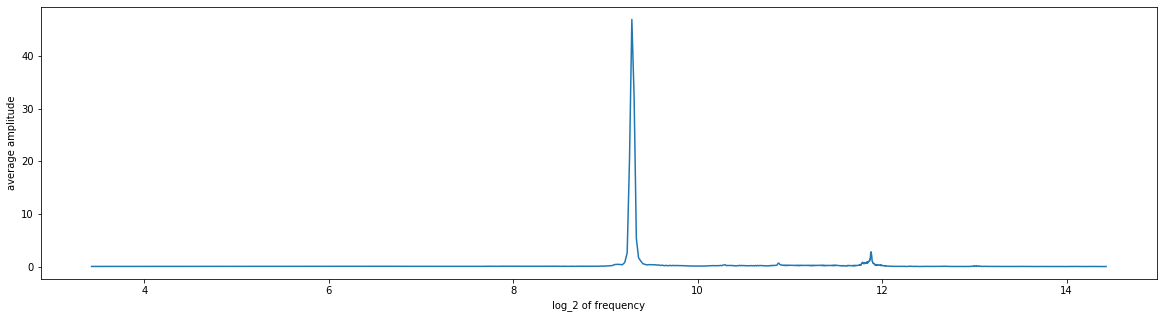

Inserting harmonic content into database...
Done!


In [9]:
process_sample(1847)